## Librerías a utilizar

In [138]:

import numpy as np
import pandas as pd
from IPython.display import HTML

import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

import plotly.graph_objects as go

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, normalize
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

from sklearn.metrics import confusion_matrix ,  classification_report

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display

pd.set_option("display.max_colwidth", 200)
pd.set_option('display.max_columns', None)



------------
## Carga de Datos

#### La base de datos se consigue en la web de [Kaggle](https://www.kaggle.com/datasets/jmmvutu/ecommerce-users-of-a-french-c2c-fashión-store) o de [Data.World](https://data.world/jfreex/e-commerce-users-of-a-french-c2c-fashión-store). También cuenta con una descricipción de las variables muy útil.


#### Debido al desbalance que presenta la BDD, se crearan subconjuntos de datos aprovechando las funciónes de ayuda suministradas por el creador para descartar todos los usuarios inactivos.

_Licencia: CC-BY-NC-SA 4.0_

In [97]:
users = pd.read_csv('users.csv')

In [8]:
# Gracias al creador del DataFrame por las funciónes
# Jeffrey's Helpers to filter dataframes 

def helper_has_fields_compared_to(df, columnas, target, what, operator):
   
    '''
        Helper to compare several columnas to the same value.
    '''

    col = columnas[0]
    if operator == '>':
        res = (df[col] > target)
    elif operator == '>=':
        res = (df[col] >= target)
    elif operator == '<=':
        res = (df[col] <= target)
    elif operator == '<':
        res = (df[col] < target)
    elif operator == '==':
        res = (df[col] == target)
    elif operator == '!=':
        res = (df[col] != target)  
    for col in columnas[1:]:
        if operator == '>':
            tmp = (df[col] > target)
        elif operator == '>=':
            tmp = (df[col] >= target)
        elif operator == '<=':
            tmp = (df[col] <= target)
        elif operator == '<':
            tmp = (df[col] < target)
        elif operator == '==':
            tmp = (df[col] == target)
        elif operator == '!=':
            tmp = (df[col] != target)
        if what == 'all':
            res = res & tmp
        elif what in ['any']:
            res = res | tmp
    return res

def helper_has_any_field_greater_than(df, columnas, target):
    #Returns lines of the dataframe where any of value of the specified columnas is greater than the target.
    res = helper_has_fields_compared_to(df, columnas, target, 'any', '>')
    return res

def helper_has_any_field_smaller_than(df, columnas, target):
    #Returns lines of the dataframe where any of value of the specified columnas is smaller than the target.
    res = helper_has_fields_compared_to(df, columnas, target, 'any', '<')
    return res

def helper_has_all_field_greater_than(df, columnas, target):
    #Returns lines of the dataframe where all of value of the specified columnas is smaller than the target.
    res = helper_has_fields_compared_to(df, columnas, target, 'all', '>')
    return res

def helper_has_all_field_smaller_than(df, columnas, target):
    #Returns lines of the dataframe where all of value of the specified columnas is smaller than the target.
    res = helper_has_fields_compared_to(df, columnas, target, 'all', '<')
    return res

def helper_has_all_field_equal_to(df, columnas, target):
    #Returns lines of the dataframe where all of value of the specified columnas is equal to the target.
    res = helper_has_fields_compared_to(df, columnas, target, 'all', '==')
    return res

In [98]:


# InActivos
Inactive_db=users[helper_has_all_field_smaller_than(
      users,
      ['socialProductsLiked', 'productsListed',
      'productsPassRate', 'productsWished',
      'productsListed','productsSold','productsBought'],
      1)]
Inactive_db.dataframeName = "Usuarios Inactivos"


# Usuarios Activos
Active_db=users[helper_has_any_field_greater_than(
      users,
      ['socialProductsLiked', 'productsListed',
      'productsPassRate', 'productsWished', 
      'productsListed','productsSold','productsBought'],
      0)]
Active_db.dataframeName = "Usuarios Activos"

# Usuarios Vendedores
Sellers_db=Active_db[helper_has_any_field_greater_than(
      Active_db,
      ['productsPassRate','productsListed','productsSold'],
      0)]
Sellers_db.dataframeName = "Usuarios Vendedores"

# Usuarios Compradores
Buyers_db=Active_db[helper_has_any_field_greater_than(
      users,
      ['productsWished','socialProductsLiked','productsBought'],
      0)]
Buyers_db.dataframeName = "Usuarios Compradores"

      

print(f"Usuarios inactivos: {Inactive_db.shape[0]:,.0f} registros con {Inactive_db.shape[1]} columnas")
#Inactive_db.sample(12)
print(f"Usuarios Activos: {Active_db.shape[0]:,.0f} registros con {Active_db.shape[1]} columnas")
print(f"Usuarios Activos representan {(Active_db.shape[0]/users.shape[0])*100:.2f}% del total de usuarios")


print(f"Usuarios Vendedores: {Sellers_db.shape[0]:,.0f} registros con {Sellers_db.shape[1]} columnas")
print(f"Usuarios Vendedores representan {(Sellers_db.shape[0]/Active_db.shape[0])*100:.2f}% de los Usuarios Activos")
print(f"Usuarios Compradores: {Buyers_db.shape[0]:,.0f} registros con {Buyers_db.shape[1]} columnas")
print(f"Usuarios Compradores representan {(Buyers_db.shape[0]/Active_db.shape[0])*100:.2f}% de los Usuarios Activos")

Usuarios inactivos: 77,274 registros con 24 columnas
Usuarios Activos: 21,639 registros con 24 columnas
Usuarios Activos representan 21.88% del total de usuarios
Usuarios Vendedores: 2,719 registros con 24 columnas
Usuarios Vendedores representan 12.57% de los Usuarios Activos
Usuarios Compradores: 20,650 registros con 24 columnas
Usuarios Compradores representan 95.43% de los Usuarios Activos


#### Los usuarios activos en web representan solo el <b>21.88% del total de usuarios</b> por lo que se trabajará solo con usuarios que tengan actividad en alguna de estas columnas:   </br>    `['socialProductsLiked', 'productsListed','productsPassRate', 'productsWished', 'productsListed','productsSold','productsBought']`

#### Los usuarios activos los segmentaremos en usuarios Vendedores y Compradores bajo la siguiente definición:
- Vendedores : <b>2,719 registros (12,57% del total de usuarios activos)</b> con actividad en al menos una de las siguientes variables `['productsPassRate','productsListed','productsSold']`
- Compradores : <b>20,650 registros (12,57% del total de usuarios activos)</b> con actividad en al menos una de las siguientes variables `['productsWished','socialProductsLiked','productsBought']`

-----------
## EDA

#### Para el análisis exploratorio inicial estudiaremos como se distribuyen las distintas columnas del dataframe.

<AxesSubplot: xlabel='seniorityAsMonths', ylabel='Count'>

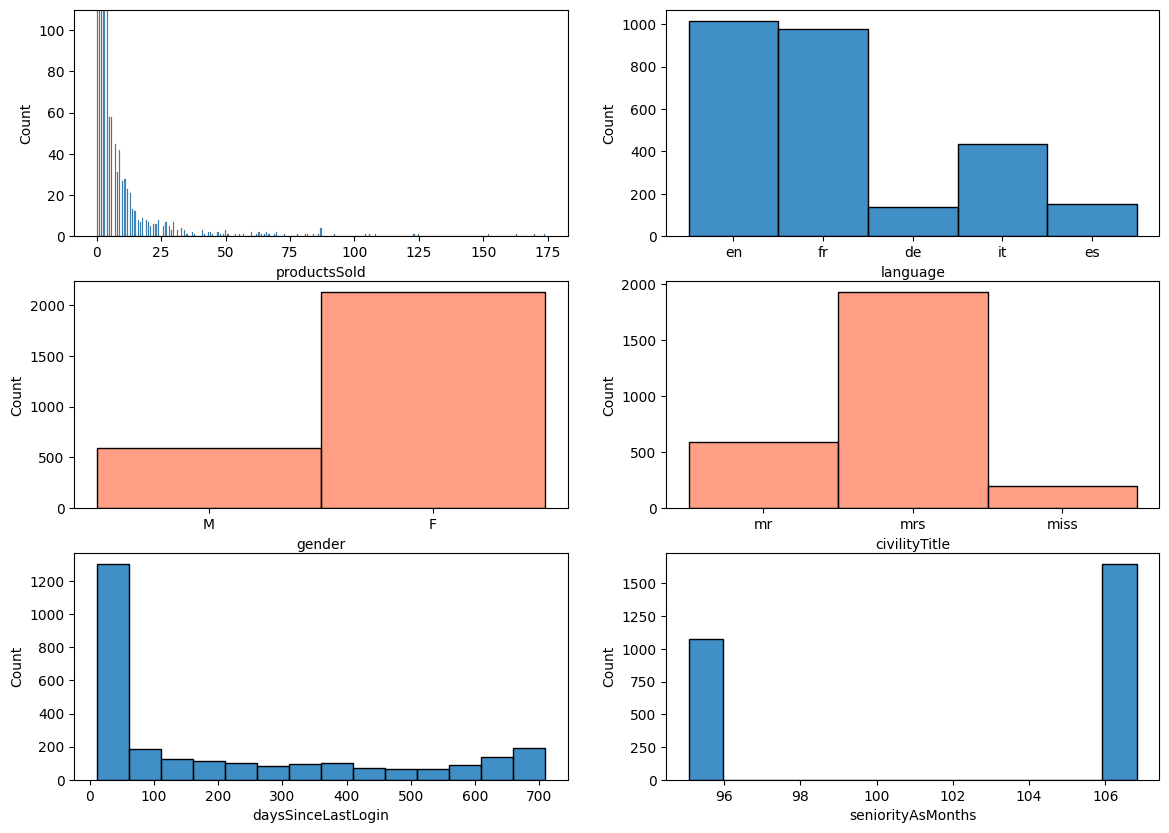

In [99]:
# Definir región del plot (3 filas, 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(14, 10))


# Crear histograma en cada subplot

t = sns.histplot(data = Sellers_db, x='productsSold', color='#006ab3', ax=axes[0,0])
t.set_ylim(0,110)
sns.histplot(data = Sellers_db.language, color='#006ab3', kde=False, ax=axes[0,1])
sns.histplot(data = Sellers_db.gender, color='#ff7f5c', kde=False, ax=axes[1,0])
sns.histplot(data = Sellers_db.civilityTitle, color='#ff7f5c', kde=False, ax=axes[1,1])
sns.histplot(data = Sellers_db.daysSinceLastLogin, color='#006ab3', kde=False, ax=axes[2,0])
sns.histplot(data = Sellers_db.seniorityAsMonths, color='#006ab3', kde=False, ax=axes[2,1])

In [100]:
print(f'Porcentaje de vendedoras: {(Sellers_db.gender.value_counts()[0]/Sellers_db.gender.value_counts().sum())*100:.2f}%')
print(f'Porcentaje de mujeres casadas: {(Sellers_db.civilityTitle.value_counts()[0]/Sellers_db.civilityTitle.value_counts().sum())*100:.2f}%')


Porcentaje de vendedoras: 78.23%
Porcentaje de mujeres casadas: 70.91%


In [101]:
# Filterin the outlier
Sellers_db = Sellers_db[Sellers_db.socialProductsLiked < 12000]

Sellers_db.describe().T

,count,mean,std,min,25%,50%,75%,max
identifierHash,2718,66197007752197504,5287655177485779968,-9221801386431225856,-4491133488490256384,123203279601082608,4545613513454628352,9204738082147465216
socialNbFollowers,2718,10,16,3,4,5,9,353
socialNbFollows,2718,16,179,0,8,8,8,8268
socialProductsLiked,2718,40,270,0,0,1,11,7044
productsListed,2718,3,12,0,0,1,2,244
productsSold,2718,4,12,0,0,1,3,174
productsPassRate,2718,30,42,0,0,0,77,100
productsWished,2718,16,100,0,0,0,2,1916
productsBought,2718,2,12,0,0,0,1,405
civilityGenderId,2718,2,1,1,2,2,2,3


In [102]:
Sellers_db.groupby(['language'])['productsSold'].agg({'count','mean'})

,mean,count
language,,
de,4,140
en,5,1017
es,6,150
fr,3,979
it,6,432


#### Inglés y francés son los idiomas más hablados por los vendedores del e-Commerce por lo que crearemos variables indicatrices para ver si el vendedor es angloparlante, o si es francoparlante
#### Las mujeres representan 78% de los vendedores, y las mujeres casadas representan el 70,9% de este grupo.
#### Notoriamente la variable _Antigüedad_ (`seniority`) presenta una distribución uniforme focalizada en dos puntos separados por 10 meses entre sí: Suponemos que la data está corrupta o se habilitaron los registros de nuevos usuarios solamente en el décimo y en el primer mes de actividad de la web. Esta irregularidad nos induce a descartarla en la etapa de modelaje.
#### La variable _Días desde Última Conexión_ (`daysSinceLastLogin`) señala que la mayoría de los vendedores presentan menos de 100 días de inactividad. Destaca un leve pico en el extremo superior que corresponde a todos los vendedores que no usan la plataforma desde que se registraron.
#### El subconjunto de vendedores está sesgado hacia la izquierda de la distribución (__las medianas de las variables numéricas son menores que los de las medias__): esto significa que la mayoría de los datos se hayan por debajo del promedio
#### Los vendedores en promedio </br> -  Tienen 5 seguidores y en casos notables alcanzan a 353 seguidores </br>  -  Ha concretado 1 venta </br> - La mayoría no utiliza las funciónes sociales de la web _socialProductsLiked_ _productsWished_.


### Análisis de Correlación


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'socialNbFollowers'),
  Text(1.5, 0, 'socialNbFollows'),
  Text(2.5, 0, 'socialProductsLiked'),
  Text(3.5, 0, 'productsListed'),
  Text(4.5, 0, 'productsSold'),
  Text(5.5, 0, 'productsPassRate'),
  Text(6.5, 0, 'productsWished'),
  Text(7.5, 0, 'productsBought'),
  Text(8.5, 0, 'daysSinceLastLogin'),
  Text(9.5, 0, 'seniority')])

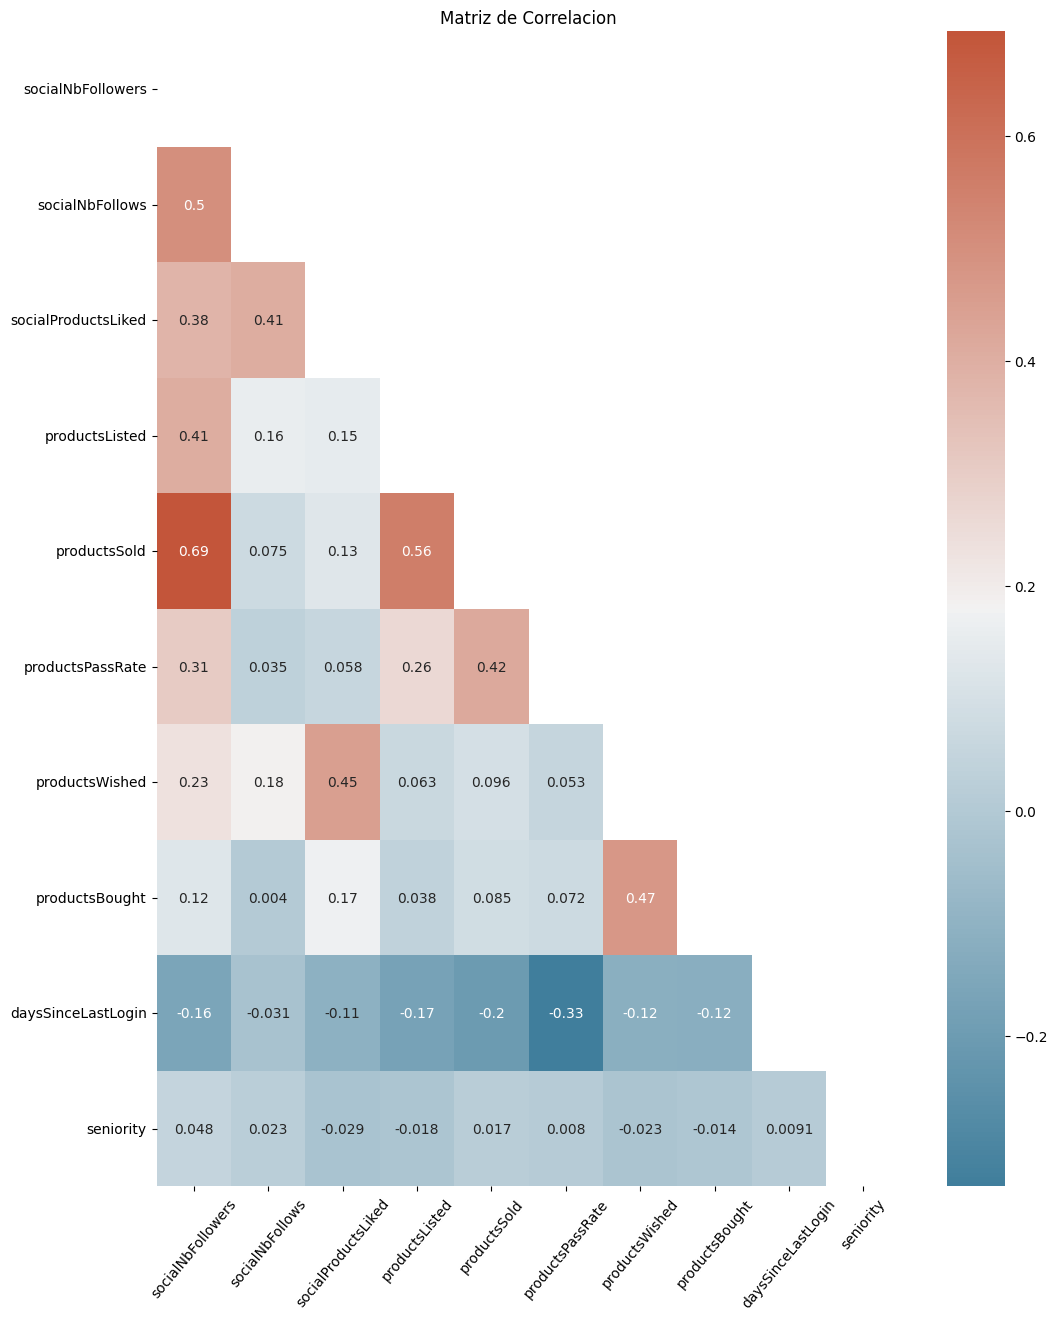

In [14]:
cols = ['language',
 'socialNbFollowers',
 'socialNbFollows',
 'socialProductsLiked',
 'productsListed',
 'productsSold',
 'productsPassRate',
 'productsWished',
 'productsBought',
 'daysSinceLastLogin',
 'seniority'
 ]

corr = Sellers_db[cols].corr()
#
# Set up the matplotlib plot configuration
#
f, ax = plt.subplots(figsize=(12, 15))
#
# Generate a mask for upper traingle
#
mask = np.triu(np.ones_like(corr, dtype=bool))
#
# Configure a custom diverging colormap
#
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
h = sns.heatmap(corr, annot=True, mask = mask, cmap=cmap).set(title='Matriz de Correlacion')
plt.xticks(rotation=50)

### Matriz de Correlaciónes:

#### __Altas__ : </br> - `socialFollows` x `socialProductsLiked` : Asumiendo que los likes señalan aquellos productos que interesan a los usuarios, la alta correlación puede ser explicada por la tendencia entre los usuarios a seguir a los vendedores de productos que les interesan. </br> - `socialFollows` x `socialFollowers`: Se presume es relevante para los usuarios tener gran cantidad de seguidores, o que se impulsa la política de _follow por follow_ para solidificar su presencia en la web. </br> - `productsSold` x `socialNbFollowers`: Se presume que a mayores unidades vendidas, aumenta la cantidad de seguidores.

#### __Medias__: </br> - `ProductsWished` x `socialProductsLiked`: Este valor indica que los usuarios distinguen entre los items que les gustan y los items que en verdad desean, y además sugiere que de los items que reciben likes solo les interesa comprar la mitad </br> - `ProductsWished` x `productsBought`: Sugiere que los usuarios que aprovechan la Wish List tambien se inclinan por realizar más compras

#### __Bajas__: </br> - `daysSinceLastLogin` x `productsSold`: Se explica porque es poco probable que los usuarios de alta inactividad (+14 dÍas desde su ultimo LogIn) coloquen productos a la venta y consigan venderlos. </br> - `daysSinceLastLogin` x `productsPassRate`: Se explica porque aquellos vendedores de alta inactividad seguramente no aprenden los estandares de uso y calidad que establece el e-Commerce, de forma que recibieron una mala calificaciÓn por el equipo validador en el momento que colocaron algun producto a la venta.

#### Crearemos variables indicatrices que : </br> - Distinga si el usuario es o no __angloparlante__ y si es o no __francoparlante__ </br> - Distingan si el usuario es __masculino o femenino__ </br> - Distinga si el usuario tiene entre __30, 60 o mas de dias de inactividad__ </br> - Clasifiquen a los vendedores por su __total de productos vendidos__

#### Crearemos estimadores que nos resuman la actividad de los vendedores en la web: </br> - Un indicador que determine la __calidad de los productos__ del vendedor </br> - Un estimador que capture la actividad social del usuario con __otros usuarios__ </br> - Un estimador que capture la actividad social del usuario con __productos a la venta__

In [103]:

cut_labels = ['Low end', 'Frequent seller', 'High reach']
Sellers_db =  Sellers_db.assign(
                            anglophone = np.where(Sellers_db.language== 'en', 1,0),
                            francophone = np.where(Sellers_db.language== 'fr', 1,0),
                            isFem = np.where(Sellers_db.gender == 'F', 1, 0),
                            productsQuality =  (Sellers_db.productsListed * (Sellers_db.productsPassRate/100)) + Sellers_db.productsSold,
                            socialAct_1 =  (Sellers_db.socialNbFollowers + Sellers_db.socialNbFollows),
                            socialAct_2 = (Sellers_db.socialProductsLiked + Sellers_db.productsWished)/2,
                            dropout_30 = np.where(Sellers_db.daysSinceLastLogin > 30, 1,0),
                            dropout_60 = np.where(Sellers_db.daysSinceLastLogin > 60, 1,0),
                            dropout_90 = np.where(Sellers_db.daysSinceLastLogin > 90, 1,0),
                            seller_type = pd.qcut(Sellers_db.productsSold.rank(pct=True), q=4, duplicates='drop', labels=cut_labels).astype("string")
                           )

#### Estudiaremos la posible relación entre el total de _Productos Vendidos_ (`productsSold` : la variable objetivo) y las demás variables numéricas

#### Comprobamos la correlación que existe entre las variables _Productos Listados_( `productsListed`), _Ratio de Productos Aprobados_(`productsPassRate`), _Número de Seguidores_ (`socialNbFollowers`) con el total de _Productos Vendidos_.

#### Aunque pareciera que hay que ajustar con un componente cuadrático el _Ratio de Productos Aprobados_ en caso de considerarlo para una regresión.

#### A su vez nos interesa graficar las variables de insumo para el estimador de _Actividad Social 2_ para justificar que se hayan divididos los indicadores de actividad social ya que, en su uso diario con la web, los vendedores poco necesitan interactuar con los productos de otros vendedores

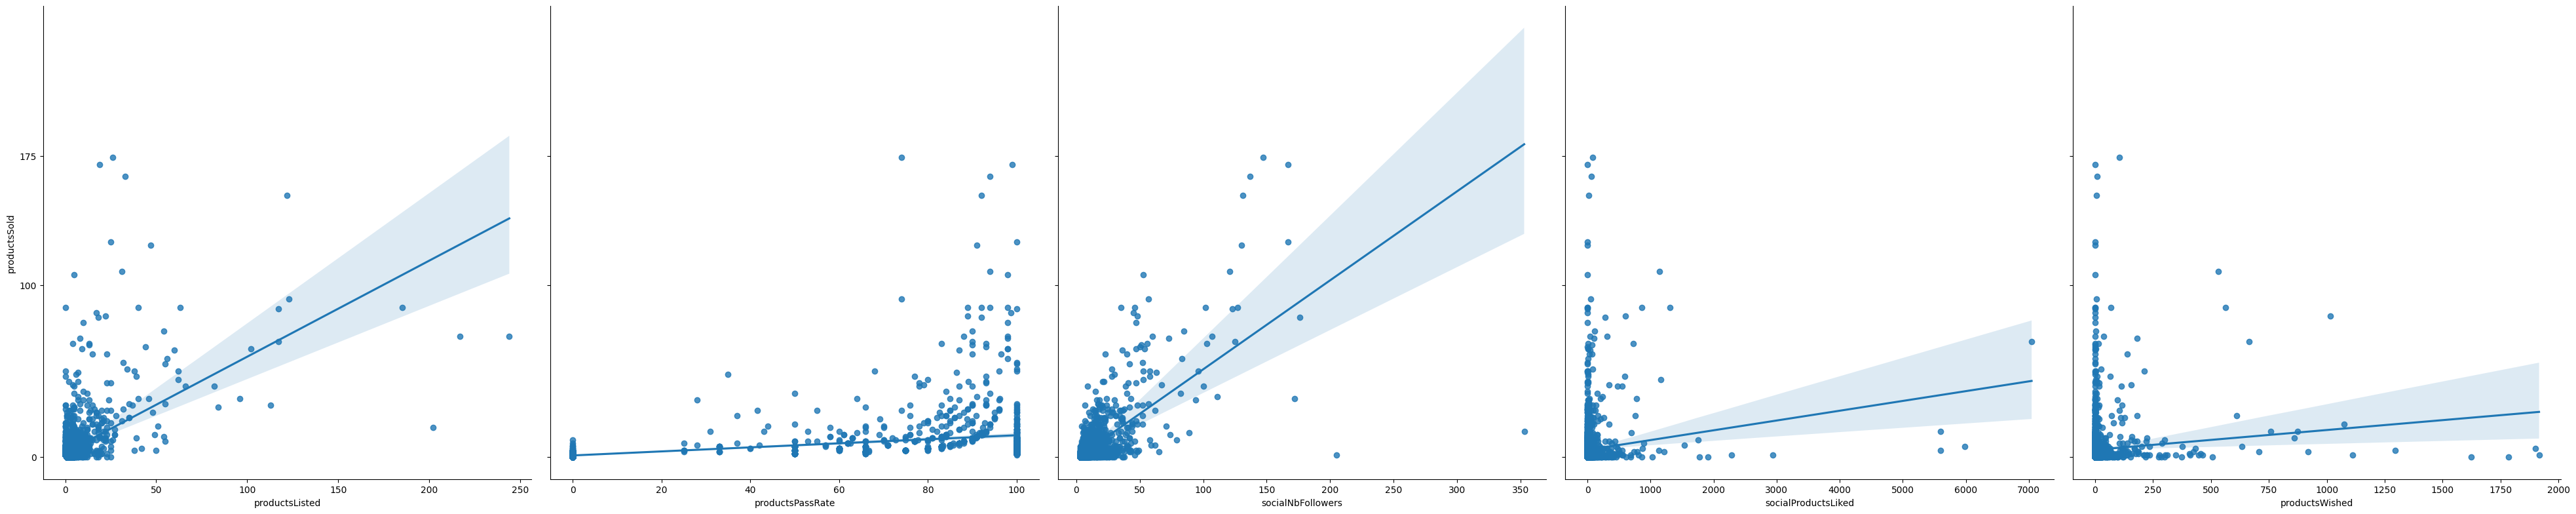

In [16]:
# CHECAR RELACión LINEAR ENTRE VARIABLES PREDICTORAS Y VARIABLE OBJETIVO PARA LOS VENDEDORES
g = sns.PairGrid(Sellers_db, y_vars=["productsSold"], x_vars=["productsListed", "productsPassRate", 'socialNbFollowers', 'socialProductsLiked', 'productsWished'], height=8)
g.map(sns.regplot)
g.set( yticks=[0, 100, 175])

#### Nos interesa tambien ver la relación entre nuestras variables predictivas tomando en cuenta el indicador de _Clase de Vendedor_ creado.

<AxesSubplot: xlabel='socialNbFollowers', ylabel='productsListed'>

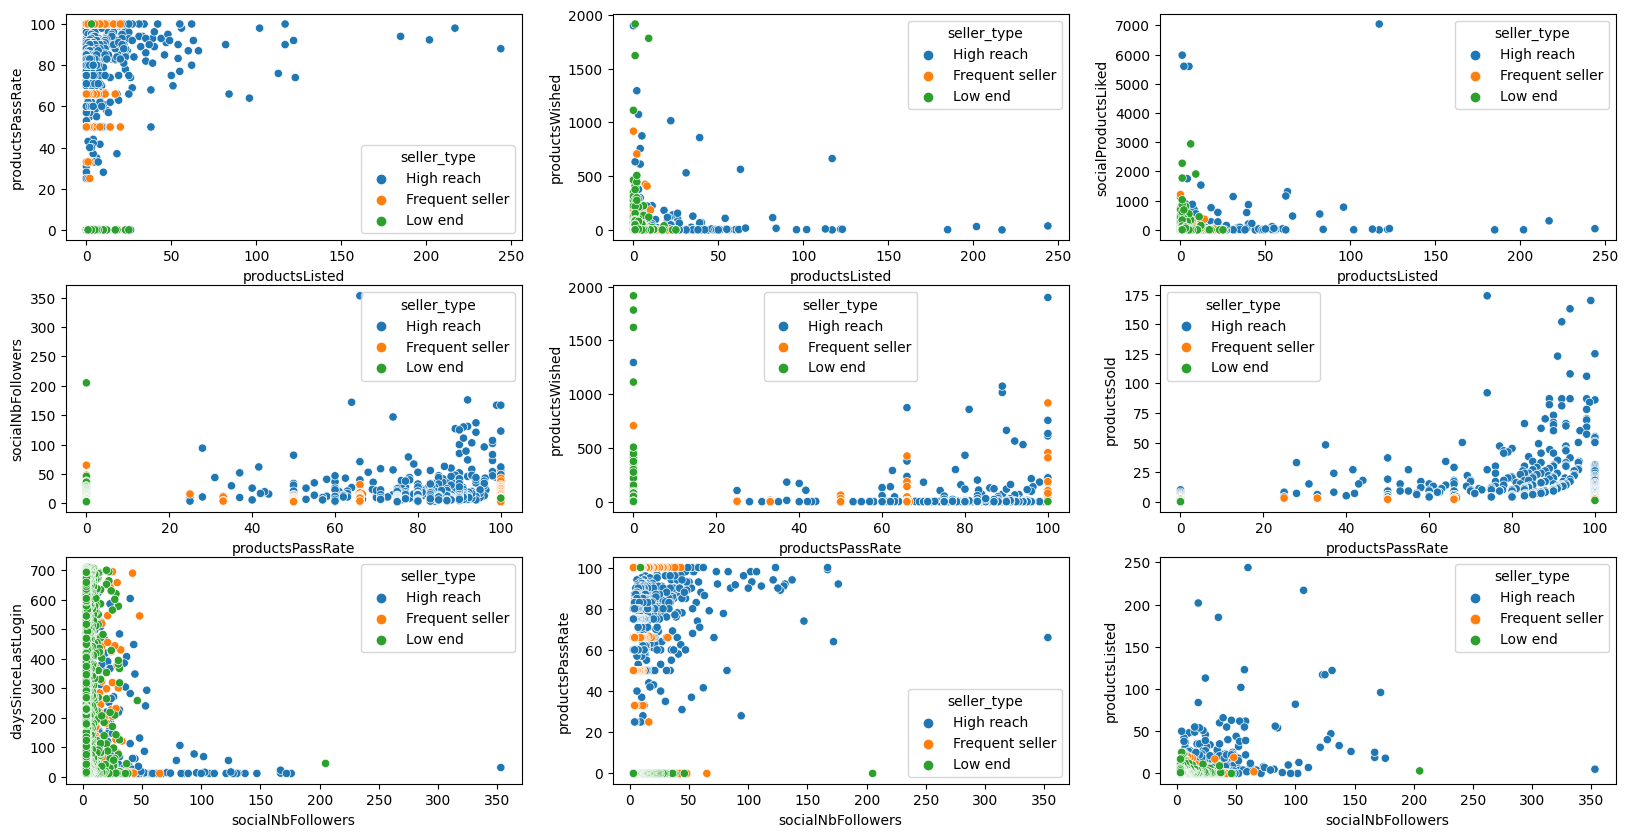

In [17]:
# RELACión LINEAR RESALTANDO CLASE DE VENDEDOR
fig2, axes2 = plt.subplots(3, 3, figsize=(20, 10))

sns.scatterplot(data=Sellers_db, x="productsListed", y="productsPassRate",hue='seller_type',  ax=axes2[0,0])
sns.scatterplot(data=Sellers_db, x="productsListed", y="productsWished", hue='seller_type', ax=axes2[0,1])
sns.scatterplot(data=Sellers_db, x="productsListed", y="socialProductsLiked",hue='seller_type', ax=axes2[0,2])
sns.scatterplot(data=Sellers_db, x="productsPassRate", y="socialNbFollowers", hue='seller_type', ax =axes2[1,0])
sns.scatterplot(data=Sellers_db, x="productsPassRate", y="productsWished", hue='seller_type', ax =axes2[1,1])
sns.scatterplot(data=Sellers_db, x="productsPassRate", y="productsSold", hue='seller_type', ax =axes2[1,2])
sns.scatterplot(data=Sellers_db, x="socialNbFollowers", y="daysSinceLastLogin", hue='seller_type', ax =axes2[2,0])
sns.scatterplot(data=Sellers_db, x="socialNbFollowers", y="productsPassRate", hue='seller_type', ax =axes2[2,1])
sns.scatterplot(data=Sellers_db, x="socialNbFollowers", y="productsListed", hue='seller_type', ax =axes2[2,2])


In [104]:
## Helper function for checking proportions of values within the column
def dist(column) -> str:

    '''
        Function that returns an string that represents the percentual proportion that each value has in the column. 
        column :: DataFrame column of categorical values (shouldn'nt be used with numerical values)
    '''
    description = ''
    
    for i in range(len(column.unique())):
        description += f'{column.value_counts().index[i]}: {(column.value_counts()[i]/column.value_counts().sum())*100:.2f}% \n'
    
    return description


print(dist(Sellers_db.seller_type))

Low end: 58.87% 
High reach: 23.51% 
Frequent seller: 17.62% 



#### Los vendedores de _Bajo prospecto_ (`Low end`) representan __más de la mitad (58,9%)__ del total : </br> - La mayoría de los usuarios con mas de 90 dias de inactividad están en este grupo </br> - No tienen más de 50 seguidores y tienen menos de 40 productos a la venta </br> - A excepción de un atipico con calificación perfecta (100 `productsPassRate`), todos se ubican en el espectro inferior del indicador (cerca de 0) 

#### Los vendedores de _Alto Alcance_ (`High reach`) representan __casi un cuarto (23,5%)__ del total  : </br> - La mayoría de los vendedores no presentan periodos extensos de inactividad </br>

-----
## Prediccion volumen de Venta

#### Deseamos generar un modelo que nos permita estimar con el menor error posible la cantidad de un productos que venderá un cliente de determinadas características. Utilizaremos solo las variables que nos interesan en los sets de entrenamiento y prueba.

#### Se formula y entrena un modelo que nos permita segmentar de manera más eficiente los vendedores del e-Commerce.

In [107]:
# Easily get column names users.columns.to_list()
cate_columns = [
    'anglophone',
    'francophone',
    'isFem',
    'dropout_30',
    'dropout_60',
    'dropout_90']

numerical_columns = [
    'socialAct_1',
    'socialAct_2',
    'productsQuality',
    'daysSinceLastLogin',
    'seniority']

target = ['productsSold', 'productsBought']

users_revised = pd.concat([Sellers_db[cate_columns], Sellers_db[numerical_columns], Sellers_db[target[0]]], axis=1)
users_revised = users_revised[users_revised['socialAct_1']<2000]
print("Dataset original", Sellers_db.shape)
print("Dataset luego de filtrar variables:\n",users_revised.shape)

print(f"\n Columnas del Final Test: \n {users_revised.columns.to_list()}")
print(f"\n Final test data: \n {users_revised.shape}")

Dataset original (2718, 34)
Dataset luego de filtrar variables:
 (2715, 12)

 Columnas del Final Test: 
 ['anglophone', 'francophone', 'isFem', 'dropout_30', 'dropout_60', 'dropout_90', 'socialAct_1', 'socialAct_2', 'productsQuality', 'daysSinceLastLogin', 'seniority', 'productsSold']

 Final test data: 
 (2715, 12)


In [150]:
from sklearn.pipeline import make_pipeline

X = users_revised[users_revised.columns[:-1]].values
y = users_revised[users_revised.columns[-1]].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)

scorer = {'R2': 'r2',
           'MAE': 'neg_mean_absolute_error',
           'MSE': 'neg_mean_squared_error'}
           
reg_pipe = make_pipeline(RobustScaler(), LinearRegression())

scores = cross_validate(reg_pipe, X_train, y_train, scoring=scorer,
                         cv=cv, return_train_score=True)

#print(scores.keys())
print(f" R2 score: {scores['test_R2'].mean()}  \n MAE score: {scores['test_MAE'].mean()}")

 R2 score: 0.7926979984808558  
 MAE score: -1.6342285691119838


In [163]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(reg_pipe, X_train, y_train, cv=10)

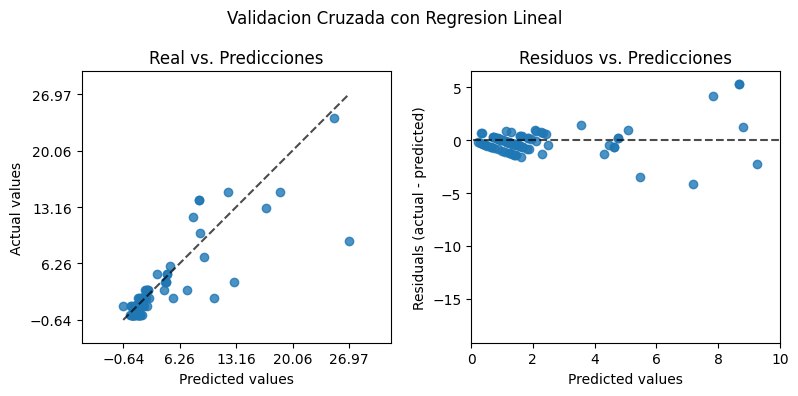

In [164]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Real vs. Predicciones")
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuos vs. Predicciones")
fig.suptitle("Validacion Cruzada con Regresion Lineal")
plt.tight_layout()
plt.xlim(0,10)
plt.show()

#### El modelo presenta un MAE de 1,51 (promediando los MAE individuales resultantes de la validación cruzada) en el set de prueba lo que no parece tan grave. 
#### El coeficiente de determinacion nos asegura que 79% de la variabilidad en el volumen de productos vendidos esta explicada por las variables de nuestros modelo.

#### Sin embargo el gráfico de residuos evidencia que no se cumplen los supuestos respecto a la normalidad y heterocedasticidad de los residuos del modelo por lo que se recomienda probar otro modelo.

#### Probaremos un modelo de regresion Ridge que buscaremos optimizar en el entrenamiento antes de enfrentarlo con la data de prueba

In [155]:
param = {
    'alpha':[.0001, 0.001,0.01, 0.01,1],
    'fit_intercept':[True,False],
    'positive':[True,False],
    'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
       }
#define model
model = Ridge()

# define search
search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X_train, y_train)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7958205964255767
Best Hyperparameters: {'alpha': 1, 'fit_intercept': False, 'positive': True, 'solver': 'auto'}


In [157]:
from sklearn.model_selection import cross_val_predict

model = Ridge(alpha= 1, fit_intercept=False, positive= True, solver = 'auto')

y_pred = cross_val_predict(model, X_train, y_train, cv=10)

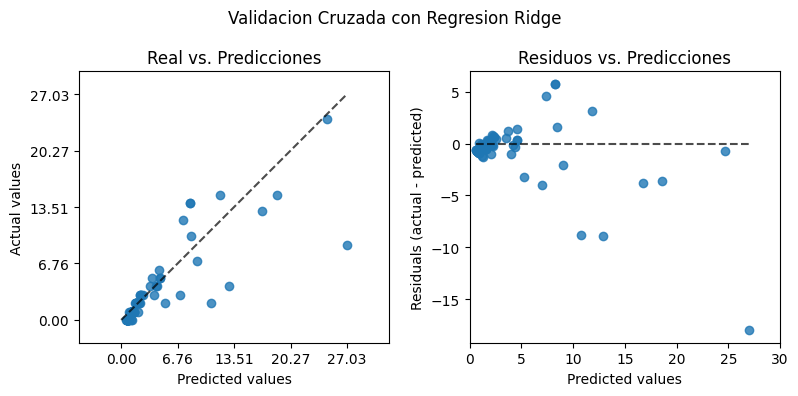

In [161]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Real vs. Predicciones")
PredictionErrorDisplay.from_predictions(
    y_train,
    y_pred=y_pred,
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuos vs. Predicciones")
fig.suptitle("Validacion Cruzada con Regresion Ridge")
plt.tight_layout()
plt.xlim(0,30)
plt.show()

#### El coeficiente de determinacion alcanza el 80% pero se siguen violando los supuestos de la regresion.

## Segmentación 
#### Proponemos un modelo de Mixtura Gaussiana para identificar todos los tipos de cliente que existen dentro del dataset.

In [38]:
scaler=RobustScaler()
dataset_temp=users_revised[['productsQuality','daysSinceLastLogin','socialAct_1']]
X = scaler.fit_transform(dataset_temp)
#X = normalize(X_std,norm='l2')

#gaussmix_pipe = make_pipeline(RobustScaler(), GaussianMixture(n_components=4, covariance_type='spherical',max_iter=2000, random_state=5))
gmm=GaussianMixture(n_components=4, covariance_type='spherical',max_iter=2000, random_state=5).fit(X)
labels = gmm.predict(X)
dataset_temp['cluster'] = labels

dataset_temp=dataset_temp.replace({'cluster': {0:'Off',3:'Need attention/Testers',1:'High potential',2:'Loyal Fans'}})

pd.options.display.float_format = "{:.0f}".format
summary=dataset_temp[['productsQuality','socialAct_1','daysSinceLastLogin','cluster']]
summary.set_index("cluster", inplace = True)
summary=summary.groupby('cluster').describe().transpose()
summary.head()

cluster                High potential  Loyal Fans  Need attention/Testers  Off
productsQuality count             163          63                     557 1932
                mean               31          95                       8    1
                std                17          70                       6    1
                min                 0           0                       0    0
                25%                23          26                       3    0

In [26]:
PLOT = go.Figure()
for C in list(dataset_temp.cluster.unique()):
    

    PLOT.add_trace(go.Scatter3d(x = dataset_temp[dataset_temp.cluster == C]['productsQuality'],
                                y = dataset_temp[dataset_temp.cluster == C]['daysSinceLastLogin'],
                                z = dataset_temp[dataset_temp.cluster == C]['socialAct_1'],                        
                                mode = 'markers',marker_size = 6, marker_line_width = 1,
                                name = str(C)))
PLOT.update_traces(hovertemplate='productsQuality: %{x} <br>daysSinceLastLogin: %{y} <br>socialActivity: %{z}')

    
PLOT.update_layout(margin={"r":0,"t":80,"l":0,"b":0}, width = 1000, height = 600, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Calidad de Productos', titlefont_color = 'black'),
                                yaxis=dict(title = 'Dias Última Conexión', titlefont_color = 'black'),
                                zaxis=dict(title = 'Actividad Social', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

#### Este poderoso indicador nos permite disenar diversas estrategias de acuerdo a las necesidades del negocio. Dos utilidades inmediatas: </br> 1) Podemos desear implementar un modelo de deserción e implementar subsecuentes estretategias de reinserción y este indicador nos facilita percibir que los clientes verdes en su mayoría ya desertaron y los puntos rojos son aquellos en riesgo de desertar: esto es el grupo en quien debemos centrar nuestros esfuerzos de reinserción. </br> 2) Identificar las características de que colocan a los puntos azules en ventaja respecto a los puntos rojos (mayor actividad social, mayor calidad de productos) permite diseñar estrategias que alienten a los vendedores a adaptarse a los lineamientos que conducta que les depara un mayor exito en el e-Commerce (mayor volumen de ventas, ampliación de publico, premiación por excelencia)
-----------

### Conclusiones

* Las mujeres representan el grueso de los vendedores (78%)
* Mas de la mitad (54,84%) de los vendedores desertaron la plataforma 
* Los _Vendedores Estrellas_ en promedio venden mas de 50 productos 
* Los _Need attention/Testers_ o se desinteresaron luego de uso inicial del servicio o estan insatisfechos con su desempeno con el e-Commerce: </br> >> 6 de cada 10 aportan el valor suficiente para ser seleccionados en una campana de reinsercion </br> >> 2 de cada 10 necesitan estrategias que fomenten una cultura de uso ajustada a las funciones sociales y reglas de calidad del negocio  
* 8 de cada 100 vendedores de _Alto potencial_ pueden convertirse  _Vendedores Estrellas_ a traves de estrategias similares al punto anterior pero personalizadas para sus caracteristicas

### Recomendaciones
* Vale la pena agregar mas variables que ahonden en otras caracteristicas economicas y sociales: </br> >> Economicas: Monto total de ventas, productos vendidos segregados por las categorias con que segmenta el e-Commerce los productos, edad de los vendedores (de no ser posible: la fecha de establecimiento es un buen proxy), maximo nivel educativo adquirido 
* Usar otro estimador para la cantidad de productos vendidos de un vendedor determinado






In [ ]:
users_revised['cluster'] = labels
users_revised= users_revised.replace({'cluster': {0:'Off',3:'Need attention/Testers',1:'High potential',2:'Loyal Fans'}})

In [60]:
resume_df = users_revised.groupby(['seller_type','cluster'])['productsSold'].agg({'count','mean'}).sort_index(level=0,ascending=False)
resume_df

mean  count
seller_type     cluster                            
Low end         Off                        1   1489
                Need attention/Testers     1    104
                Loyal Fans                 0      2
                High potential             1      4
High reach      Off                        4     83
                Need attention/Testers     8    342
                Loyal Fans                59     60
                High potential            21    152
Frequent seller Off                        2    360
                Need attention/Testers     2    111
                Loyal Fans                 3      1
                High potential             3      7

Made with infinite love by [212ldavidr](https://instagram.com/212ldavidr) 

In [167]:
557/resume_df['count'].sum()

0.20515653775322285